In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import sys
# add the src directory to sys.path so notebook can import project modules
sys.path.append(str(Path('..') / 'src'))

from data_loading import load_clean_data, TICKERS
import features
import models_baseline

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

In [7]:
TICKERS

['AAPL', 'MSFT', 'SPY', 'QQQ', 'TLT', 'GLD']

In [8]:
df_aapl = load_clean_data("AAPL")
df_aapl.head()

,Date,Close,Open,High,Low,Volume,Change
0,2015-01-02,27.33,27.85,27.86,26.84,212820000.0,-0.0095
1,2015-01-05,26.56,27.07,27.16,26.35,257140000.0,-0.0282
2,2015-01-06,26.57,26.64,26.86,26.16,263190000.0,0.0000
3,2015-01-07,26.94,26.80,27.05,26.67,160420000.0,0.0140
4,2015-01-08,27.97,27.31,28.04,27.17,237460000.0,0.0384


In [9]:
df_aapl.dtypes

Date      datetime64[ns]
Close            float64
Open             float64
High             float64
Low              float64
Volume           float64
Change           float64
dtype: object

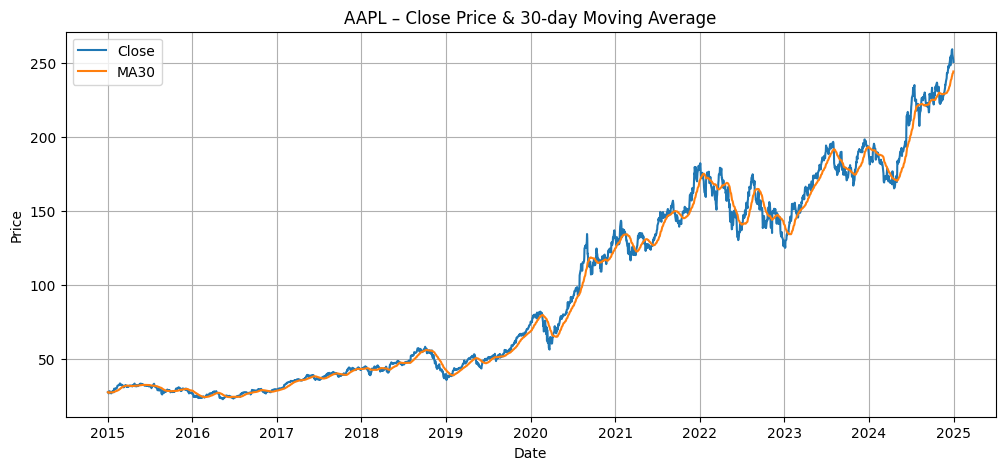

In [10]:
df_aapl = df_aapl.copy()
df_aapl["MA30"] = features.compute_moving_average(df_aapl, window=30)

plt.figure(figsize=(12, 5))
plt.plot(df_aapl["Date"], df_aapl["Close"], label="Close")
plt.plot(df_aapl["Date"], df_aapl["MA30"], label="MA30")
plt.title("AAPL – Close Price & 30-day Moving Average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [11]:
asset_stats = features.compute_all_assets_metrics()
asset_stats_df = pd.DataFrame(asset_stats).T  # tickers as index

asset_stats_df

,annual_return,annual_volatility,sharpe
AAPL,0.262582,0.284734,0.922204
MSFT,0.257156,0.271520,0.947100
SPY,0.120546,0.176770,0.681937
QQQ,0.184520,0.218279,0.845343
TLT,-0.026037,0.153250,-0.169901
GLD,0.084516,0.140485,0.601597


In [12]:
returns_dict = features.compute_all_daily_returns()
corr = features.compute_correlation_matrix(returns_dict)

corr

,AAPL,MSFT,SPY,QQQ,TLT,GLD
AAPL,1.000000,-0.004468,0.511830,0.002329,-0.132094,-0.034169
MSFT,-0.004468,1.000000,-0.043635,0.860857,0.057343,-0.030445
SPY,0.511830,-0.043635,1.000000,-0.030027,-0.224221,-0.022280
QQQ,0.002329,0.860857,-0.030027,1.000000,0.030849,-0.016932
TLT,-0.132094,0.057343,-0.224221,0.030849,1.000000,0.165863
GLD,-0.034169,-0.030445,-0.022280,-0.016932,0.165863,1.000000


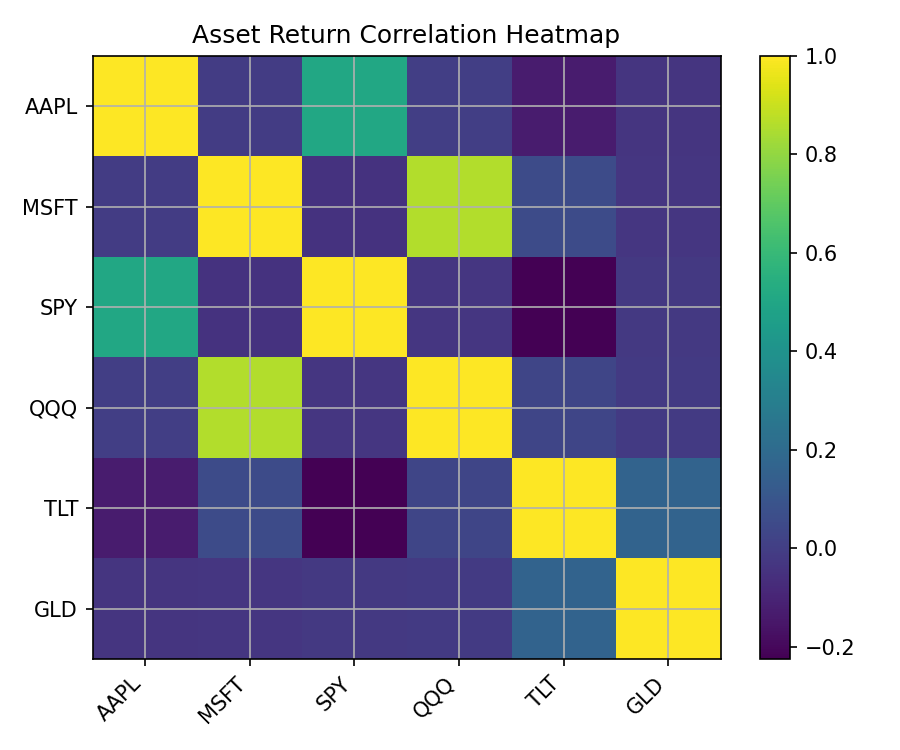

In [13]:
features.plot_correlation_heatmap(corr)
from IPython.display import Image
Image(filename="../outputs/figures/correlation_heatmap.png")

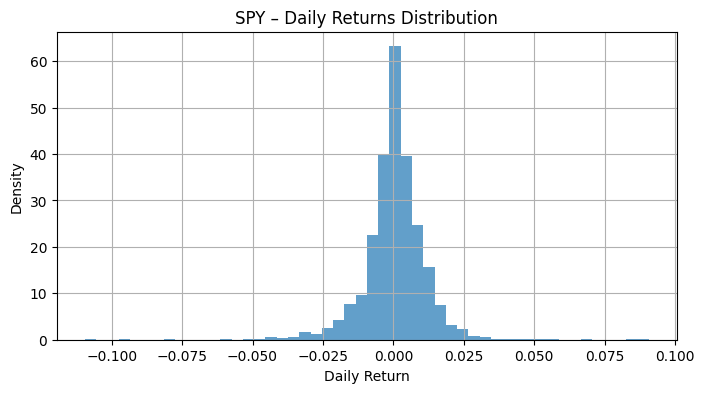

In [14]:
rets_spy = returns_dict["SPY"].dropna()

plt.figure(figsize=(8, 4))
plt.hist(rets_spy, bins=50, density=True, alpha=0.7)
plt.title("SPY – Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.show()

In [15]:
# Clean SPY prices
df_spy = load_clean_data("SPY").copy()
df_spy = df_spy.set_index("Date")
price_spy = df_spy["Close"]

# Naive ve MA(30) forecast örneği
horizon = 30

naive_forecast = models_baseline.naive_forecast_last_value(price_spy, horizon=horizon)
ma_forecast = models_baseline.moving_average_forecast(price_spy, window=30, horizon=horizon)

naive_forecast[:5], ma_forecast[:5]

(array([586.08, 586.08, 586.08, 586.08, 586.08]),
 array([598.403, 598.403, 598.403, 598.403, 598.403]))

In [16]:
exp_ret_30d_spy = models_baseline.compute_expected_return_30d_from_history(price_spy)
exp_vol_30d_spy = models_baseline.compute_expected_vol_30d_from_history(price_spy)

exp_ret_30d_spy, exp_vol_30d_spy

(0.012239696187986149, 0.04352175223750672)

In [17]:
baseline_forecasts = models_baseline.build_baseline_forecasts()
baseline_df = pd.DataFrame(baseline_forecasts).T

baseline_df

,expected_return_30d,expected_vol_30d
AAPL,0.051300,0.059158
MSFT,0.009241,0.074093
SPY,0.012240,0.043522
QQQ,0.025732,0.059912
TLT,-0.043648,0.051298
GLD,-0.004292,0.056844


In [18]:
from pathlib import Path
import json

json_path = Path("../outputs/json/forecasts_baseline.json")
with json_path.open() as f:
    forecasts_from_file = json.load(f)

forecasts_from_file["SPY"]

{'expected_return_30d': 0.012239696187986149,
 'expected_vol_30d': 0.04352175223750672}